In [65]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

In [66]:
dados = pd.read_csv('../dados/Bicicletas.csv')
dados.head()

,clima,temperatura,bicicletas_alugadas
0,2,0.363625,985
1,2,0.353739,801
2,1,0.189405,1349
3,1,0.212122,1562
4,1,0.229270,1600


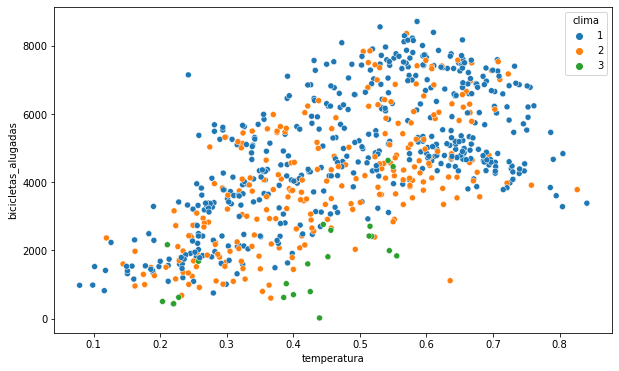

In [67]:
ax = sns.scatterplot( x = 'temperatura', y = 'bicicletas_alugadas', data = dados,
                hue = 'clima', palette = 'tab10')
ax.figure.set_size_inches(10,6)

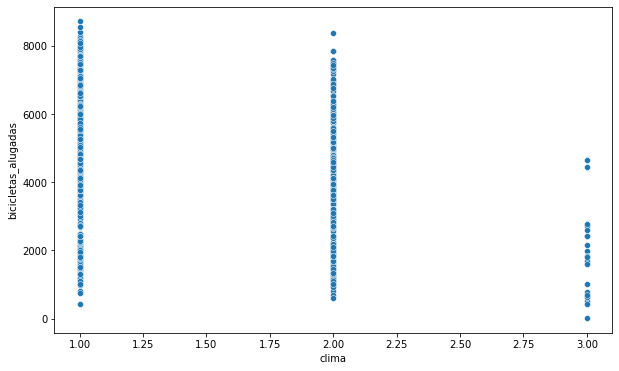

In [68]:
ax = sns.scatterplot( x = 'clima', y = 'bicicletas_alugadas', data = dados)
ax.figure.set_size_inches(10,6)

In [69]:
y = dados.bicicletas_alugadas.values
X = dados[['clima', 'temperatura']].values

In [70]:
xmax = np.argmax(X, axis = 0)
X = X/xmax


In [71]:
ymax = np.argmax(y, axis = 0)
y = y/ymax


In [72]:
def sigmoid(soma):
    return 1/(1+np.exp(-soma))

In [73]:
def relu(soma):
    return np.maximum(0, soma)

In [74]:
arquitetura = [
    {'dim_entrada' : 2, 'dim_saida' : 50, 'ativacao' :"relu"},
    {'dim_entrada' : 50, 'dim_saida' : 1, 'ativacao' : "sigmoid"}

]

In [75]:
def inicia_camadas(arquitetura, seed = 99):
    # inicia os valores aleatórios
    np.random.seed(seed)

    # numero de camadas da rede neural
    numero_de_camadas = len(arquitetura)

    # inicia armazenamento de parametros
    valores_parametros = {}

    # itera nas camadas da rede
    for indice, camada in enumerate(arquitetura):

        indice_camada = indice + 1
        
        # extrai o numero de nodos nas camadas
        tamanho_camada_entrada = camada['dim_entrada']
        tamanho_camada_saida = camada['dim_saida']

        # inicia os valores na matriz de pesos P
        # e o vetor de viés ou bias b
        valores_parametros['P' + str(indice_camada)] = np.random.randn(tamanho_camada_saida, tamanho_camada_entrada) * 0.1
        valores_parametros['b' + str(indice_camada)] = np.random.randn(tamanho_camada_saida, 1) * 0.1

    return valores_parametros

In [76]:
def propaga_uma_camada(ativado_anterior, pesos_atuais, b_atual, ativacao = 'relu'):
    # cálculo da entrada para a função de ativação
    saida_atual = np.dot(pesos_atuais, ativado_anterior) + b_atual

    # selecção da função de ativação
    if ativacao is 'relu':
        func_ativacao = relu
    elif ativacao is 'sigmoid':
        func_ativacao = sigmoid
    else:
        raise Exception('Ainda não implementamos essa funcao')
    
    # retorna a ativação calculada Ativado_atual e a matriz intermediária Saida
    return func_ativacao(saida_atual), saida_atual

In [77]:
def propaga_total(X, valores_parametros, arquitetura):
    # memoria temporaria para a retropropagacao
    memoria = {}
    # O vetor X é a ativação para a camada 0 
    ativado_atual = X
    
    # iterações para as camadas
    for indice, camada in enumerate(arquitetura):
        # a numeração das camadas começa de 1
        indice_camada = indice + 1
        # utiliza a ativação da iteração anterior
        ativado_anterior = ativado_atual

        # extrai a função de ativação para a camada atual
        func_ativacao_atual = camada['ativacao']

        # extrai os pesos da camada atual
        pesos_atuais = valores_parametros['P' + str(indice_camada)]
        # extrai o bias para a camada atual
        b_atual = valores_parametros['b' + str(indice_camada)]
        
        # cálculo da ativação para a camada atual
        ativado_atual, saida_atual = propaga_uma_camada(ativado_anterior, pesos_atuais, b_atual, func_ativacao_atual)

        # salca os valores calculados na memória
        memoria['A' + str(indice)] = ativado_anterior
        memoria['Z' + str(indice_camada)] = saida_atual
    
    # retorna o vetor predito e um dicionário contendo os valores intermediários
    return ativado_atual, memoria


In [78]:
valores_parametros = inicia_camadas(arquitetura,)


In [79]:
y_estimado, memoria = propaga_total(np.transpose(X), valores_parametros, arquitetura)

In [80]:
y_estimado[0,0] *ymax

333.89048538889745

In [81]:
y[0]*ymax

984.9999999999999

In [82]:
def valor_de_custo(Y_predito, Y):
    m = Y_predito.shape[1]
    custo = -1/m * (np.dot(Y, np.log(Y_predito).T) + np.dot(1-Y, np.log(1 - Y_predito).T))
    return np.squeeze(custo)

In [83]:
def atualiza(valores_parametros, gradientes, arquitetura, taxa_aprendizagem):
    for indice_camada, camada in enumerate(arquitetura, 1):
        valores_parametros['P' + str(indice_camada)] -= taxa_aprendizagem*gradientes['dP' + str(indice_camada)]
        valores_parametros['b' + str(indice_camada)] -= taxa_aprendizagem * gradientes['db' + str(indice_camada)]
    return valores_parametros

In [84]:
def retropropagacao_total(Y_predito, Y, memoria, valores_parametros, arquitetura):
    gradientes = {}

    Y = Y.reshape(Y.predito.shape)

    d_ativado_anterior = -(np.divide(Y, Y_predito)) - np.divide(1-Y, 1-Y_predito)

    for indice_camada_anterior, camada in reversed(list(enumerate(arquitetura))):
        indice_camada_atual = indice_camada_anterior + 1

        funcao_ativacao_atual = camada[ativacao]
        
        d_ativado_atual = d_ativado_anterior

        ativado_anterior = memoria['A' + str(indice_camada_anterior)]
        saida_atual = memoria['Z' + str(indice_camada_atual)]

        pesos_atuais = valores_parametros['P' + str(indice_camada_atual)]
        b_atual = valores_parametros['b' + str(indice_camada_atual)]

        d_ativado_anterior, d_pesos_atuais, db_atual = retropropagacao_uma_camada(d_ativado_atual, pesos_atuais, b_atual, 
                                                                                    saida_atual, ativado_anterior, funcao_ativacao_atual)
        
        gradientes['dP' + str(indice_camada_atual)] = d_pesos_atuais
        gradientes['dB' + str(indice_camada_atual)] = db_atual

        return gradientes




In [85]:
def sigmoid_retro(d_ativado, saida):
    sig = sigmoid(saida)
    return d_ativado * sig * (1-sig)

In [86]:
def relu_retro(d_ativado, saida):
    d_saida = np.array(d_ativado, copy = True)
    d_saida[saida <= 0] = 0
    return d_saida

In [ ]:
def retropropagacao_uma_camada(d_ativado_atual, pesos_atuais, b_atual, saida_atual, ativado_anterior)